## Metric Learning - сиамская сеть для верификации лиц на датасете LFW

Обучение эмбеддингов

LFW в tensorflow-datasets: http://vis-www.cs.umass.edu/lfw/

LFW official page: https://www.tensorflow.org/datasets/catalog/lfw

In [78]:
import tensorflow_datasets as tfds
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from utils.plot_utils import plot_image_grid
from math import sqrt as sq
from collections import Counter
from tqdm.notebook import tqdm
import imageio
from skimage.transform import resize

In [2]:
tf.__version__

'2.1.0'

## Загрузка данных

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

Неплохая база лиц на 13.233 k изображений

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    urls=['http://vis-www.cs.umass.edu/lfw'],
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Нормализация и батчинг

In [5]:
# константы

N = 10
BATCH_SIZE = 64
NUM_EPOCHS = 100

In [6]:
class SiameseNetworkDataset():
    
    '''Клас предобработки датасета:'''
    
    def __init__(self,train_ds=train_ds, N=N, BATCH_SIZE=BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS):        
        self.train_ds = train_ds 
        self.N = N
        self.BATCH_SIZE = BATCH_SIZE
        self.NUM_EPOCHS = NUM_EPOCHS
        
        
    #  Возвращает список имен с наибольшим кол-вом изображений
    def get_name(self, train_ds, N):
        train_ds_shape = tf.data.experimental.cardinality(train_ds).numpy()
        names_list = [x[0].numpy().decode('utf-8') for x in iter(train_ds.take(train_ds_shape))]
        most_common_names = Counter(names_list).most_common(N)
        
        most_common_names_list = []
        for name in most_common_names:
            most_common_names_list.append(name[0])   
        MAP_SET = {}
        for iterations, names in enumerate(most_common_names_list):
            MAP_SET[names] =  iterations
        return most_common_names, most_common_names_list, MAP_SET
    
    # Возвращает семплы изображений из списка 
    def get_data_name(self, train_ds, N):
        
        most_common_names, most_common_names_list, MAP_SET = self.get_name(train_ds, N)
        
        lst_train_ds = list(train_ds.as_numpy_iterator())
        new_dataset_list = []
        for examples in tqdm(lst_train_ds):
            if examples[0].decode('utf8') in most_common_names_list:
                new_dataset_list.append(examples)
                
        for n in tqdm(range(len(new_dataset_list))):
            new_dataset_list[n] = list(new_dataset_list[n])
            new_dataset_list[n][0] = np.array(MAP_SET[new_dataset_list[n][0].decode('utf8')])
                
        train_x = new_dataset_list[0][1].reshape(-1, 250, 250, 3)
        train_y = [new_dataset_list[0][0]]
        for imgs in tqdm(new_dataset_list[1:]):
            train_x = np.vstack((train_x, imgs[1].reshape(-1, 250, 250, 3)))
            train_y.append(imgs[0])
        return train_x, train_y
            
        
    # препроцессор: нормализация, батчинг       
    def dataset_processing(self, train_ds, N, BATCH_SIZE, NUM_EPOCHS):
        
        train_x, train_y = self.get_data_name(train_ds, N)
        
        train_y = np.array(train_y)
        train_x = train_x.astype(np.float32) / 255.
        
        train_df = tf.data.Dataset.from_tensor_slices((train_x, train_y))
        train_df = train_df.shuffle(buffer_size=train_x.shape[0])
        train_df = train_df.repeat(NUM_EPOCHS)
        train_df = train_df.batch(BATCH_SIZE)
        
        return train_df, train_x, train_y

## Визуализация

In [8]:
def plot_image_grid(x, y, n):
    plt.figure(figsize=(16,10))
    for i in range(n):
        plt.subplot(sq(n)+1,sq(n),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i].reshape(250,250,3))
        plt.xlabel(y[i].decode().replace("_", " "))
    plt.show()

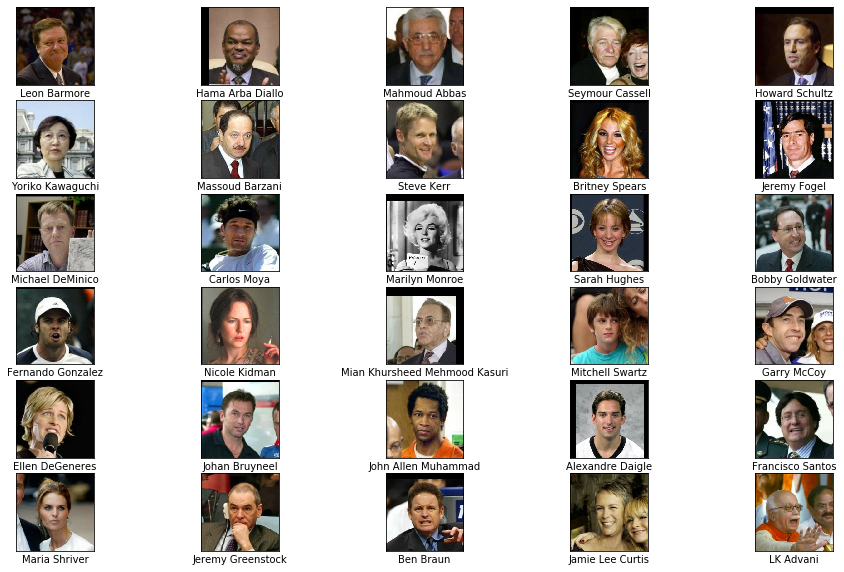

In [10]:
n_show = 30
sample = next(iter(train_ds))

# В данном датасете [0] элементом являются метки класса, [1] - само изображение
sample_img = sample[1].numpy()[:n_show]
sample_labels = sample[0].numpy()[:n_show]

plot_image_grid(sample_img, sample_labels, n_show)

## Построение и обучение модели

In [36]:
SND = SiameseNetworkDataset()

In [39]:
train_ds, train_x, train_y = SND.dataset_processing(train_ds, N, BATCH_SIZE, NUM_EPOCHS)

In [40]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [41]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [42]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [44]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    if iteration % 50 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 67.03549194335938
[50] Loss: 25.174875259399414
[100] Loss: 16.86271858215332
[150] Loss: 17.750743865966797
[200] Loss: 12.787054061889648
[250] Loss: 13.53709602355957
[300] Loss: 10.473489761352539
[350] Loss: 10.346519470214844
[400] Loss: 7.5970988273620605
[450] Loss: 9.641261100769043
[500] Loss: 6.416046142578125
[550] Loss: 3.6856496334075928
[600] Loss: 4.6159868240356445
[650] Loss: 2.7635152339935303
[700] Loss: 6.537892818450928
[750] Loss: 6.592998504638672
[800] Loss: 6.145888805389404
[850] Loss: 4.578003406524658
[900] Loss: 4.848701477050781
[950] Loss: 10.68363094329834
[1000] Loss: 2.384935140609741
[1050] Loss: 1.1606923341751099
[1100] Loss: 0.7076804637908936
[1150] Loss: 3.407402515411377
[1200] Loss: 1.7376532554626465
[1250] Loss: 2.386772632598877
[1300] Loss: 0.6711301803588867
[1350] Loss: 0.38447195291519165
[1400] Loss: 0.6012537479400635
[1450] Loss: 0.7445002198219299
[1500] Loss: 0.5854150652885437
[1550] Loss: 0.38698074221611023
[1600] Loss

## Оценка результатов

In [51]:
emb_size = 100
embs = model(train_x[:emb_size])

In [73]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [74]:
test_x_flat = train_x.reshape(-1, 250*250*3)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:emb_size])
labels_for_viz = train_y[:emb_size]

### Визуализация образцов в 2D пространстве с помощью TSNE

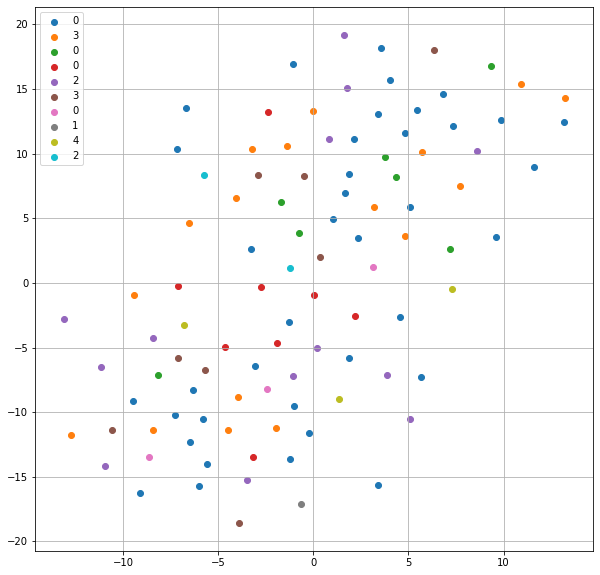

In [75]:
draw_embeddings(test_x_2D, labels_for_viz, labels_for_viz)

### Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [76]:
test_embs_2D = TSNE(n_components=2).fit_transform(embs)
labels_for_viz = train_y[:emb_size]

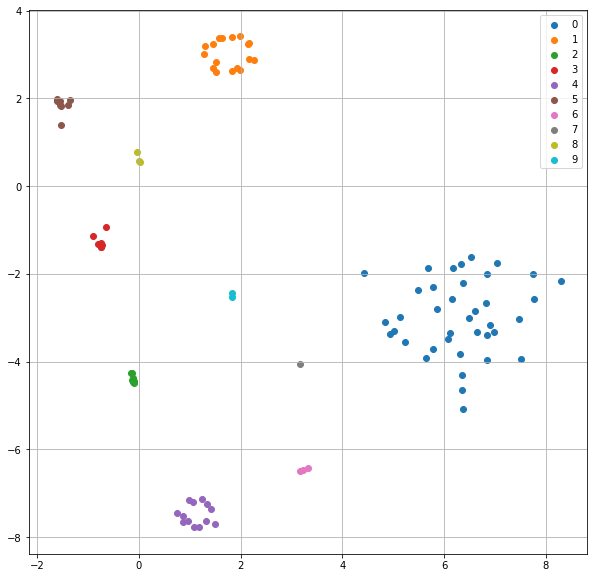

In [77]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(N)))

### Тестирование на новых данных

In [119]:
def load_and_prepare_image(fpath):
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, IMG_SHAPE, mode='reflect', anti_aliasing=True)
    img = np.reshape(img, IMG_SHAPE)
    return img

def predict_embed_on_imagefile(model, imagefilepath):
    img = load_and_prepare_image(imagefilepath)
    return model(img.reshape([1,250,250,3]))

def predict_embed_on_imagearray(model, imagearray):
    return model(imagearray.reshape([1,250,250,3]))

# Среднеквадратичное расстояние между предиктами
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [120]:
# Custom samples
img_a1 = load_and_prepare_image('./test_images/my1.jpg')
img_a1_predict = predict_embed_on_imagearray(model, img_a1)

img_a2 = load_and_prepare_image('./test_images/my2.jpg')
img_a2_predict = predict_embed_on_imagearray(model, img_a2)

# LFW samples
test_sample_face1_predict = predict_embed_on_imagearray(model, sample[1][0].numpy())
test_sample_face1_name = sample[0][0].numpy().decode().replace("_", " ")

test_sample_face2_predict = predict_embed_on_imagearray(model, sample[1][1].numpy())
test_sample_face2_name = sample[0][1].numpy().decode().replace("_", " ")

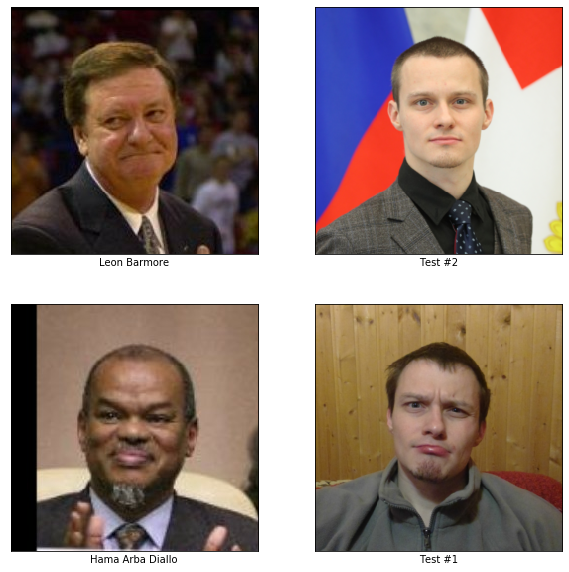

In [122]:
# Визуализация

test_names = ["Test #1", "Test #2", test_sample_face1_name, test_sample_face2_name]
test_images = [img_a1, img_a2, sample[1][0].numpy(), sample[1][1].numpy()]

tmp_list = list(zip(test_names, test_images))
random.shuffle(tmp_list)
test_names, test_images = zip(*tmp_list)

plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].reshape(250,250,3))
    plt.xlabel(test_names[i])
plt.show()

In [128]:
print("Self compare Self\n")
print('Test #1 <-> Test #2: ', diff(img_a1_predict, img_a2_predict))
print("Self compare Sample1\n")
print('Test #1 <-> %s: ' % test_sample_face1_name, diff(img_a1_predict, test_sample_face1_predict))
print('Test #2 <-> %s: ' % test_sample_face1_name, diff(img_a2_predict, test_sample_face1_predict))
print("Self compare Sample2\n")
print('Test #1 <-> %s: ' % test_sample_face1_name, diff(img_a1_predict, test_sample_face2_predict))
print('Test #2 <-> %s: ' % test_sample_face1_name, diff(img_a2_predict, test_sample_face2_predict))

Self compare Self

Test #1 <-> Test #2:  10.275888639387912
Self compare Sample1

Test #1 <-> Leon Barmore:  3.8185735383914015
Test #2 <-> Leon Barmore:  8.200850689188725
Self compare Sample2

Test #1 <-> Leon Barmore:  10.244237629128426
Test #2 <-> Leon Barmore:  4.317640695935596
